# Stress Relaxation Protocol Validation

**Validates stress relaxation data: G(t) = σ(t)/γ₀ (relaxation modulus vs time)**

## Protocol Description

Stress relaxation experiments apply a constant strain (γ₀) and measure the resulting stress σ(t) over time.
The relaxation modulus G(t) = σ(t)/γ₀ characterizes the material's time-dependent stress response.

## Validation Checks

1. **Schema validation**: Required columns present (time, modulus or stress)
2. **Finite values**: No NaN or Inf in data arrays
3. **Positive time**: t > 0 (strictly positive)
4. **Monotonic time**: Time strictly increasing
5. **Positive modulus**: G(t) > 0
6. **Monotonic decay**: G(t) monotonically decreasing (or plateau for solids)

## Standard Plots

- G(t) vs t (log-log)
- G(t) vs t (semi-log)

In [1]:
# Configuration
MODE = "FAST"  # "FAST" or "FULL"

if MODE == "FAST":
    MAX_FILES = 2
    SKIP_HEAVY_PLOTS = True
    SAVE_ARTIFACTS = False
else:
    MAX_FILES = None
    SKIP_HEAVY_PLOTS = False
    SAVE_ARTIFACTS = True

print(f"Running in {MODE} mode")

Running in FAST mode


In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add project root to path
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from examples.verification.utils.validation_utils import (
    DatasetValidation,
    ValidationResult,
    check_finite,
    check_monotonic,
    check_positive,
    create_output_directories,
    discover_files_by_protocol,
    get_data_dir,
    plot_relaxation,
    print_validation_summary,
    write_validation_report,
)

print(f"Project root: {project_root}")

Project root: /Users/b80985/Projects/rheojax


## A) Dataset Inventory

In [3]:
data_dir = get_data_dir()
files = discover_files_by_protocol(data_dir, "stress_relaxation")

# Filter to main relaxation files
files = [f for f in files if "stressrelaxation" in f.name.lower() or "relaxation" in f.name.lower() or "rel_" in f.name.lower()]

print(f"Found {len(files)} stress relaxation data files:")
for i, f in enumerate(files):
    print(f"  {i+1}. {f.relative_to(data_dir)}")

if MAX_FILES is not None:
    files = files[:MAX_FILES]
    print(f"\nProcessing {len(files)} files (FAST mode)")

Found 15 stress relaxation data files:
  1. relaxation/polymers/polypropylene_relaxation.csv
  2. relaxation/clays/rel_lapo_1200.csv
  3. relaxation/clays/rel_lapo_1800.csv
  4. relaxation/clays/rel_lapo_2400.csv
  5. relaxation/clays/rel_lapo_3600.csv
  6. relaxation/clays/rel_lapo_600.csv
  7. relaxation/biological/stressrelaxation_fishmuscle_data.csv
  8. relaxation/polymers/stressrelaxation_hdpe_data.csv
  9. relaxation/foams/stressrelaxation_liquidfoam_data.csv
  10. relaxation/polymers/stressrelaxation_pp_data.csv
  11. relaxation/polymers/stressrelaxation_ps130_data.csv
  12. relaxation/polymers/stressrelaxation_ps145_data.csv
  13. relaxation/polymers/stressrelaxation_ps160_data.csv
  14. relaxation/polymers/stressrelaxation_ps175_data.csv
  15. relaxation/polymers/stressrelaxation_ps190_data.csv

Processing 2 files (FAST mode)


## B) Data Loading

In [4]:
def load_relaxation_data(file_path: Path) -> tuple[np.ndarray, np.ndarray, str]:
    """Load stress relaxation data with format auto-detection.
    
    Returns:
        Tuple of (time, G, status_message)
    """
    # Try different separators
    for sep in ["\t", ",", ";"]:
        try:
            df = pd.read_csv(file_path, sep=sep)
            if len(df.columns) >= 2:
                break
        except Exception:
            continue
    else:
        return None, None, "Could not parse file"
    
    # Find time column
    time_cols = [c for c in df.columns if "time" in c.lower() or c.lower() == "t"]
    if not time_cols:
        time_col = df.columns[0]
    else:
        time_col = time_cols[0]
    
    # Find modulus or stress column
    g_cols = [c for c in df.columns if "modulus" in c.lower() or c.lower() == "g" or "g(t)" in c.lower()]
    stress_cols = [c for c in df.columns if "stress" in c.lower() or "sigma" in c.lower()]
    
    if g_cols:
        g_col = g_cols[0]
        is_modulus = True
    elif stress_cols:
        g_col = stress_cols[0]
        is_modulus = False
    else:
        g_col = df.columns[1] if len(df.columns) > 1 else None
        is_modulus = True
    
    if g_col is None:
        return None, None, "No modulus/stress column found"
    
    try:
        time = pd.to_numeric(df[time_col], errors="coerce").values
        G = pd.to_numeric(df[g_col], errors="coerce").values
    except Exception as e:
        return None, None, f"Numeric conversion failed: {e}"
    
    # Remove NaN values
    mask = np.isfinite(time) & np.isfinite(G)
    time = time[mask]
    G = G[mask]
    
    data_type = "modulus" if is_modulus else "stress"
    return time, G, f"Loaded {len(time)} points ({data_type}) from {time_col}, {g_col}"

# Test loading
if files:
    test_file = files[0]
    time, G, msg = load_relaxation_data(test_file)
    print(f"Test load: {test_file.name}")
    print(f"  {msg}")
    if time is not None:
        print(f"  t range: [{time.min():.2e}, {time.max():.2e}] s")
        print(f"  G range: [{G.min():.2e}, {G.max():.2e}] Pa")

Test load: polypropylene_relaxation.csv
  Loaded 76 points (modulus) from Time, Relaxation Modulus
  t range: [1.00e-03, 1.11e+04] s
  G range: [1.47e+08, 3.73e+08] Pa


## C) Validation Pipeline

In [5]:
def validate_relaxation(file_path: Path) -> DatasetValidation:
    """Run all validation checks on a stress relaxation file."""
    validation = DatasetValidation(
        file_path=str(file_path),
        protocol="stress_relaxation",
    )
    
    time, G, load_msg = load_relaxation_data(file_path)
    
    if time is None:
        validation.results.append(ValidationResult(
            check_name="data_loading",
            passed=False,
            message=load_msg,
        ))
        return validation
    
    validation.results.append(ValidationResult(
        check_name="data_loading",
        passed=True,
        message=load_msg,
        details={"n_points": len(time)},
    ))
    
    # Check 1: Finite values
    validation.results.append(check_finite(time, "time"))
    validation.results.append(check_finite(G, "modulus"))
    
    # Check 2: Positive time
    validation.results.append(check_positive(time, "time", strict=True))
    
    # Check 3: Monotonic time
    validation.results.append(check_monotonic(time, "time", increasing=True, strict=True))
    
    # Check 4: Positive modulus
    validation.results.append(check_positive(G, "modulus", strict=True))
    
    # Check 5: Monotonic decay (informational)
    mono_result = check_monotonic(G, "modulus", increasing=False, strict=False)
    validation.results.append(ValidationResult(
        check_name="modulus_decay",
        passed=True,  # Informational
        message=mono_result.message + (" (expected relaxation)" if mono_result.passed else " (plateau or noise detected)"),
        details=mono_result.details,
    ))
    
    # Check equilibrium modulus (G at long times)
    n_end = max(1, len(G) // 10)
    G_eq = np.mean(G[-n_end:])
    G_0 = G[0]
    relaxation_ratio = G_eq / G_0 if G_0 > 0 else np.nan
    
    validation.results.append(ValidationResult(
        check_name="equilibrium_modulus",
        passed=True,
        message=f"G_eq/G_0 = {relaxation_ratio:.3f}" + 
                (" (liquid-like)" if relaxation_ratio < 0.1 else " (solid-like)" if relaxation_ratio > 0.5 else " (viscoelastic)"),
        details={"G_0": float(G_0), "G_eq": float(G_eq), "relaxation_ratio": float(relaxation_ratio)},
    ))
    
    validation.derived_quantities = {
        "time": time,
        "G": G,
    }
    
    return validation

In [6]:
# Run validation on all files
validations = []

for file_path in files:
    print(f"\nValidating: {file_path.name}")
    v = validate_relaxation(file_path)
    validations.append(v)
    
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")


Validating: polypropylene_relaxation.csv
  [PASS] data_loading: Loaded 76 points (modulus) from Time, Relaxation Modulus
  [PASS] finite_values_time: time: all 76 values finite
  [PASS] finite_values_modulus: modulus: all 76 values finite
  [PASS] positive_time: time: all 76 values positive (> 0)
  [PASS] monotonic_time: time: all 75 intervals strictly increasing
  [PASS] positive_modulus: modulus: all 76 values positive (> 0)
  [PASS] modulus_decay: modulus: 1/75 intervals not non-increasing (plateau or noise detected)
  [PASS] equilibrium_modulus: G_eq/G_0 = 0.409 (viscoelastic)

Validating: rel_lapo_1200.csv
  [PASS] data_loading: Loaded 33 points (modulus) from Time, Relaxation Modulus
  [PASS] finite_values_time: time: all 33 values finite
  [PASS] finite_values_modulus: modulus: all 33 values finite
  [PASS] positive_time: time: all 33 values positive (> 0)
  [PASS] monotonic_time: time: all 32 intervals strictly increasing
  [PASS] positive_modulus: modulus: all 33 values posit

## D) Standard Plots

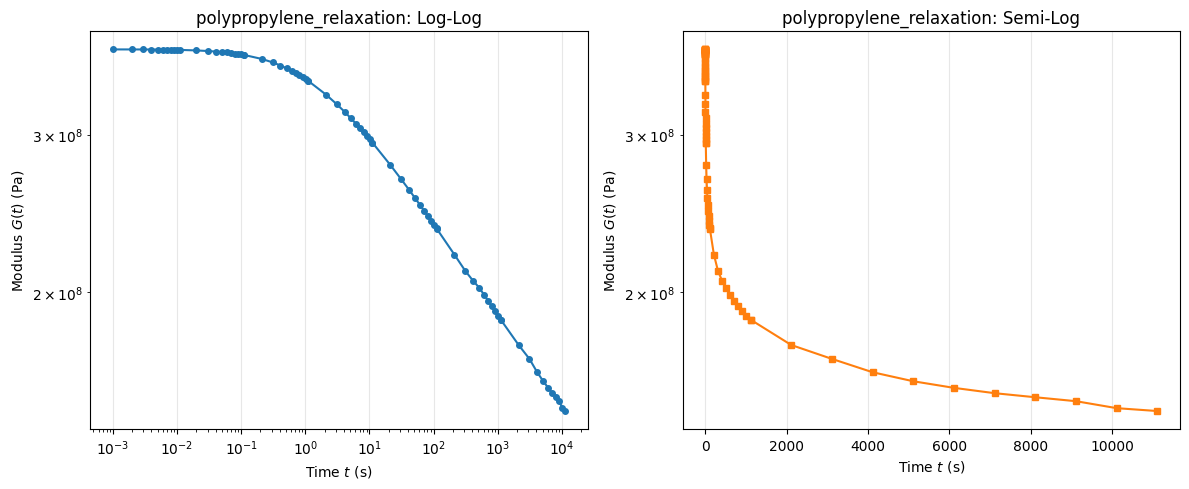

In [7]:
if not SKIP_HEAVY_PLOTS:
    output_paths = create_output_directories("stress_relaxation")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            save_path = output_paths["plots"] / f"{file_name}_relaxation.png" if SAVE_ARTIFACTS else None
            
            fig = plot_relaxation(
                v.derived_quantities["time"],
                v.derived_quantities["G"],
                save_path=save_path,
                title=file_name,
            )
            plt.show()
else:
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            fig = plot_relaxation(
                v.derived_quantities["time"],
                v.derived_quantities["G"],
                title=Path(v.file_path).stem,
            )
            plt.show()
            break

## E) Validation Summary

In [8]:
print_validation_summary(validations)


Validation Summary
File                                     Status     Passed   Failed  
--------------------------------------------------------------------------------
polypropylene_relaxation.csv             PASS       8        0       
rel_lapo_1200.csv                        PASS       8        0       
--------------------------------------------------------------------------------
TOTAL                                    ALL PASS   16       0       


## F) Export Artifacts

In [9]:
if SAVE_ARTIFACTS:
    output_paths = create_output_directories("stress_relaxation")
    
    report = {
        "protocol": "stress_relaxation",
        "mode": MODE,
        "n_files_validated": len(validations),
        "all_passed": all(v.passed for v in validations),
        "validations": validations,
    }
    
    report_path = output_paths["plots"].parent / "validation_report.json"
    write_validation_report(report, report_path)
    print(f"Validation report saved to: {report_path}")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path).stem
            df = pd.DataFrame({
                "time": v.derived_quantities["time"],
                "G": v.derived_quantities["G"],
            })
            df.to_csv(output_paths["derived_quantities"] / f"{file_name}_derived.csv", index=False)
    
    print(f"Derived quantities saved to: {output_paths['derived_quantities']}")
else:
    print("Artifacts not saved (FAST mode). Set MODE='FULL' to save.")

Artifacts not saved (FAST mode). Set MODE='FULL' to save.
